In [1]:
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse as sps

import myfm
from myfm import RelationBlock
import pandas as pd

# read movielens 1m data.
from myfm.utils.benchmark_data import MovieLens1MDataManager

In [2]:
data_manager = MovieLens1MDataManager()

In [3]:
df_train, df_test = data_manager.load_rating_kfold_split(K=10, fold=0)

# For ordered probit. rating values are now [0, 1, 2, 3, 4].
df_train.rating -= 1
df_test.rating -= 1

# Create dictionaries which map user/movie ids to internal indices.
# We have also prepared a utility class which makes this common routine easier.
# See the script version of this notebook (ml-1m-regression.py).
unique_user_ids = np.unique(df_train.user_id)
unique_movie_ids = np.unique(df_test.movie_id)
user_id_to_index = { uid: i for i, uid in enumerate(unique_user_ids)}
movie_id_to_index = { mid: i for i, mid in enumerate(unique_movie_ids)}

In [4]:
# treat the days of events as categorical variable
date_be = OneHotEncoder(handle_unknown='ignore').fit(
    df_train.timestamp.dt.floor('d').values.reshape(-1, 1)
)
def categorize_date(dates: pd):
    return date_be.transform(
        pd.to_datetime(dates).dt.floor('d').values.reshape((-1, 1))
    )

## Implement flavor of SVD++

We add "all users who have evaluated a movie in the train set" as the movie's feature.

In [5]:
# Implement side information and flavor of SVD++
# We add "all users who have evaluated a movie in the train set" or
# "all movies rated by a user" as a feture of user/movie.
use_date = True # use date info or not
use_iu = True # use implicit user feature
use_ii = True # use implicit item feature

movie_vs_watched = dict()
user_vs_watched = dict()
for row in df_train.itertuples():
    user_id = row.user_id
    movie_id = row.movie_id
    movie_vs_watched.setdefault(movie_id, list()).append(user_id)
    user_vs_watched.setdefault(user_id, list()).append(movie_id)

if use_date:
    X_date_train = categorize_date(df_train.timestamp)
    X_date_test  = categorize_date(df_test.timestamp)
else:
    X_date_train, X_date_test = (None, None)

In [6]:
# setup grouping
feature_group_sizes = []
if use_date:
    feature_group_sizes.append(
        len(date_be.categories_[0]), # date
    )

feature_group_sizes.append(len(user_id_to_index)) # user ids

if use_iu:
    feature_group_sizes.append(len(movie_id_to_index))

feature_group_sizes.append(len(movie_id_to_index)) # movie ids
                           
if use_ii:
    feature_group_sizes.append(
        len(user_id_to_index) # all users who watched the movies
    )

In [7]:
# given user/movie ids, add additional infos and return it as sparse
def augment_user_id(user_ids):
    X = sps.lil_matrix((len(user_ids), len(user_id_to_index) + (len(movie_id_to_index) if use_iu else 0) ))
    for index, user_id in enumerate(user_ids):
        if user_id in user_id_to_index:
            X[index, user_id_to_index[user_id]] = 1
        if not use_iu:
            continue
        watched_movies = user_vs_watched.get(user_id, [])
        normalizer = 1 / max(len(watched_movies), 1) ** 0.5
        for mid in watched_movies:
            if mid in movie_id_to_index:
                X[index, movie_id_to_index[mid] + len(user_id_to_index)] = normalizer
    return X.tocsr()

def augment_movie_id(movie_ids):
    X = sps.lil_matrix((len(movie_ids), len(movie_id_to_index)+ (len(user_id_to_index) if use_ii else 0 )))
    for index, movie_id in enumerate(movie_ids):
        if movie_id in movie_id_to_index:
            X[index, movie_id_to_index[movie_id]] = 1
        if not use_ii:
            continue
        watched_users = movie_vs_watched.get(movie_id, [])
        normalizer = 1 / max(len(watched_users), 1) ** 0.5
        for uid in watched_users:
            if uid in user_id_to_index:
                X[index, user_id_to_index[uid] + len(movie_id_to_index)] = normalizer
    return X.tocsr()

## Use Relation Block Format to represent the data
See [\[Rendle 2013\]](http://www.vldb.org/pvldb/vol6/p337-rendle.pdf) how comlexity dcrease drastically in this case (and most cases with bipartite graph structure).

In [8]:
# Create RelationBlock.
train_blocks = []
test_blocks = []
for source, target in [(df_train, train_blocks), (df_test, test_blocks)]:
    unique_users, user_map = np.unique(source.user_id, return_inverse=True)
    target.append(
        RelationBlock(user_map, augment_user_id(unique_users))
    )
    unique_movies, movie_map = np.unique(source.movie_id, return_inverse=True)
    target.append(
        RelationBlock(movie_map, augment_movie_id(unique_movies))
    )

### Regression

In [9]:
fm = myfm.MyFMRegressor(rank=32)
fm.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    group_shapes=feature_group_sizes,
    n_iter=512
);

alpha = 1.88 w0 = 2.31 : 100%|████████████████████████████████████████████████████████| 512/512 [19:43<00:00,  2.31s/it]


### Ordered Probit Regression

In [10]:
fm_ordered = myfm.MyFMOrderedProbit(rank=32)
fm_ordered.fit(
    X_date_train, df_train.rating.values, X_rel=train_blocks,
    group_shapes=feature_group_sizes,
    n_iter=512
);

w0 = 0.16, cutpoint = ['-2.170', '-1.122', '0.185', '1.695'] : 100%|██████████████████| 512/512 [23:23<00:00,  2.74s/it]


In [11]:
test_prediction_regressor = fm.predict(X_date_test, test_blocks)

In [18]:
test_prediction_oprobit = fm_ordered.predict_proba(X_date_test, test_blocks)

In [19]:
test_prediction_oprobit_mean = test_prediction_oprobit.dot(np.arange(5))

In [20]:
# RMSE for regressor
# you can clip the value with
test_prediction_regressor[test_prediction_regressor >=4] = 4
test_prediction_regressor[test_prediction_regressor <=0] = 0
(
    (df_test.rating.values - test_prediction_regressor)**2
).mean() ** 0.5

0.8161058248896146

In [21]:
# RMSE for ordered probit regressor
(
    (df_test.rating.values - test_prediction_oprobit_mean)**2
).mean() ** 0.5

0.8139991281742432

### Cutpoints vs ratings

A slight non-linearity seems to exist.  
That might explain why the performance improves if we use ordered probit regression.

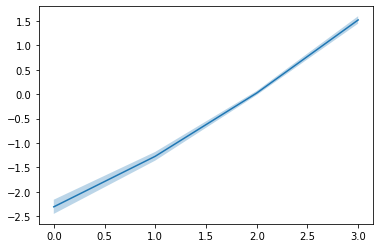

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
cutpoints = np.vstack([x.cutpoints[0] - x.w0 for x in fm_ordered.predictor_.samples])

cp_std = cutpoints.std(axis=0)
cp_mean = cutpoints.mean(axis=0)
plt.plot(cp_mean);
plt.fill_between(np.arange(4), cp_mean - 2 * cp_std, cp_mean + cp_std * 2, alpha=0.3)